# Кластеризация групп в социальной сети ВКонтакте

Для выгрузки полезных данных из групп было принято решения использовать библиотеку urlib2 для получения HTML-страниц для дальнейшего парсинга.
Был рассмотрен вариант использования Vk API, но пропускная способность у API - 3 запроса в секунду, то есть обработка данных из 75к групп займет не менее 7 часов, именно поэтому выбран парсинг "вручную". 

In [112]:
import urllib
from urllib import request
from bs4 import BeautifulSoup

# с user-agent по дефолту страница открывается как мобильная версия
opener = urllib.request.build_opener()
opener.addheaders = [('User-Agent', 'Mozilla/5.0 (X11; U; Linux i686) Gecko/20071127 Firefox/2.0.0.11')]


Основные источники информации на странице группы:
* название группы,
* описание (если есть),
* статус,
* записи со стены,
* комментарии пользователей к записям,
* количество пользователей

In [113]:
class VkGroup:
    
    def __init__(self, name, wall_records, users_cnt, status=None, description=None, comments=None):
        self.name = name
        self.status = status
        self.wall_records = wall_records
        self.users_cnt = users_cnt  
        self.description = description
        self.comments = comments
        
    def get_full_text(self):
        s = "{} {} {}".format(self.name, self.status, self.description)
        for record in self.wall_records:
            s += ' ' + record.strip()
        if self.comments != "":
            for com in self.comments:
                s += ' ' + str(com)
        return s
        
    def show(self):
        print("Название группы: {} \nСтатус: {} \nОписание: {} \nКоличество подписчиков: {}\n"
                    .format(self.name, self.status, self.description, self.users_cnt))
        
    def __str__(self):
        return ("Название группы: {} \nСтатус: {} \nОписание: {} \nКоличество подписчиков: {}"
                    .format(self.name, self.status, self.description, self.users_cnt))

Считываем данные из подготовленного файла с id групп жителей Нижнего Новгорода:

In [114]:
with open('nn_community_stats.csv') as f:
    indicies=f.read().splitlines()
    
links=list(map(lambda id:'http://vk.com/club' + id, indicies))

## Выгрузка данных

Для каждой страницы создается объект со всей необходимой информацией. Была реализована также параллельная загрузка (через Pool.map), однако, там была обнаружена проблема слишком пустых HTML-страниц (видимо, связанная с тем, что vk.com просто не успевает отдать страницу), поэтому необходимо подождать последовательной загрузки.

In [115]:
import os

# получение текста из элемента страницы
def get_text_safe(soup, selector):
    elem = soup.select_one(selector)
    return elem.get_text() if elem is not None else ""
    

# проверка, не заблокированна ли группа
def valid_page(soup):
    block_div = soup.select_one(".groups_blocked")
    private_group_div = soup.select_one(".group_info_private")
    return True if block_div is None and private_group_div is None else False

# парсинг страницы
def parse_page(soup):
    # название группы и статус
    group_name = get_text_safe(soup, ".page_name")
    status = get_text_safe(soup, "#page_current_info")
    
    # посты на стене с текстом
    wall_records = soup.select(".wall_text")
    text_wall_records = [rec.get_text() for rec in wall_records if rec.get_text() != ""]

    # описание и количество пользователей
    descr = get_text_safe(soup, ".labeled_text")
    users_cnt = get_text_safe(soup, ".header_count.fl_l")
    
    comments = soup.select(".wall_reply_text")
    text_comments = [com.get_text() for com in comments if com.get_text() != ""]
    return VkGroup(group_name, text_wall_records, users_cnt, status, descr, text_comments)

def write_to_file(filename, link):
    with open(filename, 'a') as f:
        f.write(link + '\n')

# очистка логов перед новым запуском
def remove_log(path):
    try:
        os.remove(path)
    except OSError:
        pass
    
# функция для формирования массива объектов класса VKGroup
# URL-ы с невалидными и заблокированными/приватными группами записываются в соответствующие логи
# очистка log-файлов перед запуском
good_links=[]
cnt = 0
blocked_urls_log = "blocked_urls.log"
invalid_urls_log = "invalid_urls.log"
unexpected_err_log = "unexpected_errors.log"
remove_log(blocked_urls_log)
remove_log(invalid_urls_log)
remove_log(unexpected_err_log)
def get_groups(link):
    try:
        page = opener.open(link)
        soup_page = BeautifulSoup(page, 'html.parser')
        global cnt
        cnt += 1
        if (cnt%1000 == 0):
            print("Обработанно {} групп".format(cnt))
        if valid_page(soup_page):
            vk_group = parse_page(soup_page)
            #vk_group.show()
            good_links.append(link)
            return vk_group.get_full_text().strip()
        else:
            write_to_file(blocked_urls_log, link)
    except urllib.error.HTTPError as e:
        write_to_file(invalid_urls_log, "HTTP error status {} for group {}".format(e.code, link))
    except Exception as e:
        print("Unexpected error!")
        write_to_file(unexpected_err_log, link + ':\n' + e)
    return None
 
all_groups = map(get_groups, [links[i] for i in range(200)])  # ЗАМЕНИТЬ range НА links ДЛЯ ТЕСТА НА ВСЕЙ ВЫБОРКЕ
groups = [group for group in all_groups if group]
print("Успешно обработано {} страниц сообществ".format(len(groups)))

Успешно обработано 196 страниц сообществ


Теперь можно перейти к решению непосредственно самой задачи.
<br>Для кластеризации сообществ необходимо векторизовать слова, для этого было решено проделать следующую цепочку действий:
    1. Очищаем текст и разбиваем на токены
    2. Удаляем стоп-слова
    3. Выделяем корни слов (для избежания проблем с различной формой слова)
    4. Используем TF-IDF векторизацию

## Очистка текста и разбиение на токены

Для подготовки слов для векторизации необходимо разделить текст на массив токенов, убираем стоп-слова и выделяем корни. Эксперементально было выявленно, что выделение корней значительно (на 10-15%) повышает качество кластеризации.

In [116]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import RussianStemmer
import numpy as np

# Необходимо скачать доп. пакеты для использования корпусов nltk (panlex lite не нужен), 
# если еще не скачены
# nltk.download()

# типичные для vk стоп-слова
custom_stopwords={"эт", "прост", "сегодн",  "время", "cc", "котор", "com", "наш", "групп", "vk",
                  "ден", "год", "ru", "сво" ,"сам", "ваш" , "https", "www", "http", "полност", 
                  "показа",  "очен", "gif", "feat"}
# Очистка текста
def filter_words(text):
    text = text.lower()
    tokenizer = RegexpTokenizer(r'[а-яa-z]+')
    tokens = tokenizer.tokenize(text)
    filtered_tokens = [word for word in tokens if not word in set(stopwords.words('russian')) 
                                                   and not word in set(stopwords.words('english'))]
    return filtered_tokens

# Выделение корней
def stem_tokens(text):
    stemmer = RussianStemmer()
    tokens= filter_words(text)
    stemmed_words= [stemmer.stem(token) for token in tokens if not stemmer.stem(token) in custom_stopwords]
    return stemmed_words

## Кластеризация на основе TF-IDF векторизации

Для начала был использован классический подход представления текста в группах в виде разреженной матрицы, строками которой являются текста групп, а столбцами - все слова во всех текстах. Для повышения качества мы используем не самый простой подход с подсчетом количества встречаний слова в текста в качестве значения элемента матрицы, а TF-IDF алгоритм.

In [117]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Векторизация слов
tfidf = TfidfVectorizer(tokenizer=stem_tokens)
tfs = tfidf.fit_transform(groups)      
print('TF-IDF векторизация прошла успешно')

TF-IDF векторизация прошла успешно


Наконец, перейдем к кластеризации. Был использован метод мягкой кластеризации c-means.

In [118]:
import skfuzzy

vectorized_data = tfs.T.toarray()
max_fpc = 0
max_fpc_cluster_cnt = 0

for i in np.arange(2, 15):
    cntr, u, u0, d, jm, p, fpc = skfuzzy.cmeans(vectorized_data, i, 2., error=0.005, maxiter=100, init=None)
    print('FPC: {}, число кластеров: {}'.format(fpc, i))
    if (fpc > max_fpc):
        max_fpc = fpc
        max_fpc_cluster_cnt = i
        
# используем количество кластеров с лучшим показателем fpc
print("Количество кластеров при максимальном FPC ({}): {}".format(max_fpc, max_fpc_cluster_cnt))
cntr, u_tfs, u0, d, jm, p, fpc_tfs = skfuzzy.cmeans(vectorized_data, max_fpc_cluster_cnt, 2., error=0.005, maxiter=100, init=None)

FPC: 0.500000000268783, число кластеров: 2
FPC: 0.3333333335398415, число кластеров: 3
FPC: 0.25000000014494883, число кластеров: 4
FPC: 0.20000000005668048, число кластеров: 5
FPC: 0.16666666672524355, число кластеров: 6
FPC: 0.14285714293094176, число кластеров: 7
FPC: 0.12500000003343206, число кластеров: 8
FPC: 0.111111111194875, число кластеров: 9
FPC: 0.10000000003545317, число кластеров: 10
FPC: 0.09090909094447036, число кластеров: 11
FPC: 0.08333333336738437, число кластеров: 12
FPC: 0.07692307694314053, число кластеров: 13
FPC: 0.07142857146494071, число кластеров: 14
Количество кластеров при максимальном FPC (0.500000000268783): 2


Как мы видим, тексты практически равновероятно принадлежат различным кластерам (в зависимости от количества кластеров). Видимо, данных недостаточно для такой мерности пространства и, выбирая новую точку в кластере, она все равно оказывается очень далеко от остальных точек.
<br>Попробуем проделать то же самое с word2vec.

## Word2Vec векторизация

Преимуществом word2vec является то, что в результате векторизации получается не разреженная матрица, а матрица гораздо меньшего размера (обычно от 100 до 400) и, таким образом, мерность пространства, в котором высчитывается косинусное расстояние между векторами гораздо меньше. Теоретически означает, что данный подход должен работать лучше с меньшими объемами данных. Также, используем алгоритм кластеризации хуже работает с векторами в пространстве очень большой размерности. 

Сперва, на основе текстов была создана модель:

In [119]:
import gensim
from multiprocessing import cpu_count

# составляем массив слов и обучаем модель
num_features = 100
sentences = [stem_tokens(sentence) for sentence in groups]
model = gensim.models.Word2Vec(sentences, size=num_features, window=5, min_count=3, workers=cpu_count())
print("Модель word2vec успешно построена на основе полученных текстовых данных")

Модель word2vec успешно построена на основе полученных текстовых данных


Затем, для каждой группы получен усредненный вектор. Массив таких векторов транспонируется для дальнейшего использования в алгоритме кластеризации:

In [120]:
import skfuzzy

# получаем вектор для группы на основе векторизированных представлений слов
def get_vec_for_group(words):
    vec = np.zeros((num_features,),dtype="float32")
    num_words = 0.
    # set используется для увеличения производительности
    index2word_set = set(model.index2word)
    for word in words:
        if word in index2word_set: 
            num_words += 1.
            vec = np.add(vec, model[word])
    # получаем среднее
    if num_words != 0:
        vec = np.divide(vec, num_words)
    return vec

vectorized_data_w2v = np.array([get_vec_for_group(sentence) for sentence in sentences if sentence])
vectorized_data_w2v = vectorized_data_w2v.T

print("Создание усредненных векторов для групп завершено успешно")

Создание усредненных векторов для групп завершено успешно


Далее применяем метод кластеризации и определяем количество кластеров:

In [121]:
# Кластеризуем методом C-means  
max_fpc = 0
max_fpc_cluster_cnt = 0
for i in range(2, 15): 
    cntr, u2, u0, d, jm, p, fpc = skfuzzy.cmeans(vectorized_data_w2v, i, 2., error=0.005, maxiter=1000, init=None)
    print('FPC: {}, число кластеров: {}'.format(fpc, i))
    if (fpc > max_fpc):
        max_fpc = fpc
        max_fpc_cluster_cnt = i

#Применяем кластеризацию с лучшим показателем fpc
print("Количество кластеров при максимальном FPC ({}): {}".format(max_fpc, max_fpc_cluster_cnt))
cntr, u_w2v, u0, d, jm, p, fpc_w2v = skfuzzy.cmeans(vectorized_data_w2v, max_fpc_cluster_cnt, 2., error=0.005, maxiter=1000, init=None)

FPC: 0.7793884119838619, число кластеров: 2
FPC: 0.7829215872952942, число кластеров: 3
FPC: 0.7330964423852016, число кластеров: 4
FPC: 0.7414231883743124, число кластеров: 5
FPC: 0.7410800317960238, число кластеров: 6
FPC: 0.7425432142184444, число кластеров: 7
FPC: 0.7415271725280481, число кластеров: 8
FPC: 0.7165910247615835, число кластеров: 9
FPC: 0.7090214638581579, число кластеров: 10
FPC: 0.715158980654623, число кластеров: 11
FPC: 0.6847706621986754, число кластеров: 12
FPC: 0.6886265900517585, число кластеров: 13
FPC: 0.6898868537663512, число кластеров: 14
Количество кластеров при максимальном FPC (0.7829215872952942): 3


## Отображение результатов

Отнесем групп к кластерам, к которым они принадлежат с наибольшей вероятностью:

In [122]:
def get_cluster_labels(u):
    labels=[]
    m = u.shape[1]
    n = u.shape[0]
    for j in range(m):
        maxi = 0
        mx = u[0][j]
        for i in range(n):
            if u[i][j] >= mx:
                mx = u[i][j]
                maxi=i
        labels.append(maxi)
    return labels

Для того, чтобы отобразить полученные результаты в двумерном пространстве был применен **метод главных компонент (PCA)** для уменьшение размерности с минимальными потерями информации:

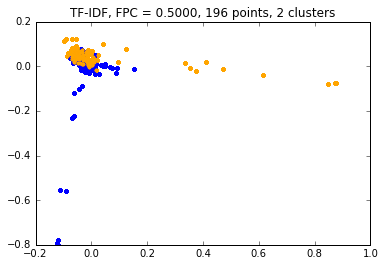

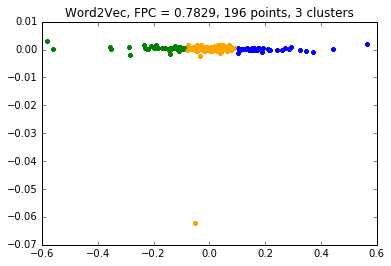

In [123]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

densed_tfs_data = tfs.todense()
data2D_tfs = PCA(n_components=2).fit_transform(densed_tfs_data)
data2D_w2v = PCA(n_components=2).fit_transform(vectorized_data_w2v.T)

def visualization(u, data2D, title, fpc):
    colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen', 'magenta', 'cyan']
    labels = get_cluster_labels(u)
    data2D = np.array(data2D)
    labels = np.array(labels)
    fig0, ax0 = plt.subplots()
    for label in labels:
        ax0.plot(data2D[labels == label, 0],data2D[labels == label,1], '.',
                 color=colors[label])
    fpc_str = "{0:.4f}".format(fpc)
    ax0.set_title('{}, FPC = {}, {} points, {} clusters'.format(title, fpc_str, data2D.shape[0], u.shape[0]))
    
visualization(u_tfs, data2D_tfs, "TF-IDF", fpc_tfs)
visualization(u_w2v, data2D_w2v, "Word2Vec", fpc_w2v)

Таким образом, мы видим, что на имеющихся объемах данных лучше себя показывает word2vec. Далее будем использовать эти результы для определения тематики:

In [124]:
u_final = u_w2v

Для интереса можно вывести еще несколько вариантов кластеризации от word2vec:

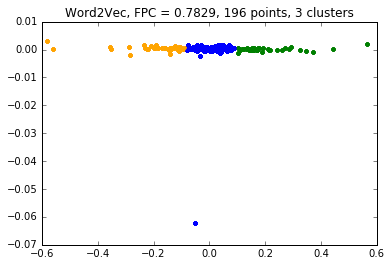

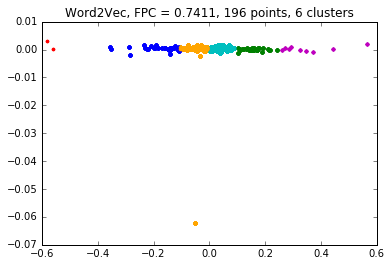

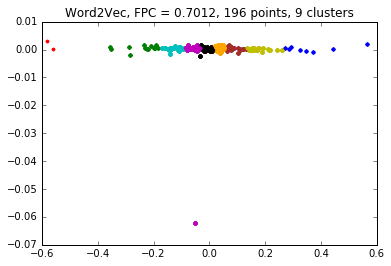

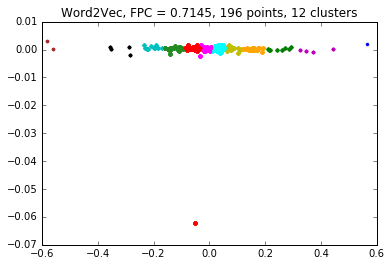

In [125]:
for i in np.arange(3,13,3):
    cntr, u2, u0, d, jm, p, fpc = skfuzzy.cmeans(vectorized_data_w2v, i, 2., error=0.005, maxiter=1000, init=None)
    data2D_w2v = PCA(n_components=2).fit_transform(vectorized_data_w2v.T)
    visualization(u2, data2D_w2v, "Word2Vec", fpc)

## Определение тематики

Для выявление тематики в полученных кластерах был использован метод **латентного размещения Дирихле (LDA)**:

In [126]:
from gensim import corpora, models

# получаем темы для каждого кластера
labels = get_cluster_labels(u_final)
labels_arr = np.array(labels)
sentences_arr = np.array(sentences)
for label in range(u_final.shape[0]):
    # превращаем токенизированные документы в id <-> term словарь
    cluster_sentences = sentences_arr[labels_arr == label]
    dictionary = corpora.Dictionary(cluster_sentences)
    corpus = list(map(dictionary.doc2bow, cluster_sentences))
    # создаем модель на основе предложений в кластере
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=100, id2word = dictionary, passes=20) 
    print("Темы для кластера № " + str(label + 1))
    map(print, ldamodel.print_topics(5))
    for topic in ldamodel.print_topics(5):
        print(topic)
    print('\n')

Темы для кластера № 1
(18, '0.069*осен + 0.044*врем + 0.037*урож + 0.037*лочк + 0.033*utzih + 0.029*сен + 0.022*люб + 0.022*сердечк + 0.022*ставьт + 0.011*цвет')
(56, '0.023*выйд + 0.023*девушк + 0.012*люд + 0.012*так + 0.012*друг + 0.012*дела + 0.012*кажд + 0.012*цен + 0.012*трат + 0.012*хочеш')
(11, '0.000*жизн + 0.000*люд + 0.000*кажд + 0.000*друг + 0.000*отношен + 0.000*постоя + 0.000*человек + 0.000*сложн + 0.000*част + 0.000*момент')
(65, '0.000*приложен + 0.000*iphon + 0.000*нов + 0.000*ссылк + 0.000*люд + 0.000*сообщен + 0.000*счастлив + 0.000*люб + 0.000*скача + 0.000*созда')
(32, '0.025*втор + 0.019*слаб + 0.019*гениальн + 0.017*тех + 0.017*добр + 0.016*жизн + 0.014*лиш + 0.013*мно + 0.013*половинк + 0.013*мо')


Темы для кластера № 2
(69, '0.018*iphon + 0.013*коп + 0.013*час + 0.011*дал + 0.010*мужск + 0.010*качеств + 0.010*рубл + 0.009*id + 0.008*теб + 0.008*пост')
(63, '0.000*друг + 0.000*мир + 0.000*работ + 0.000*ярмарк + 0.000*так + 0.000*масл + 0.000*нужн + 0.000*водол 

Результат выполнения предыдущей ячейки - 5 строк для каждого кластера, которые представляют собой 5 тем (их легко понять по содержимому строк).

# Подведение итогов

В ходе выполнения задания было выявленно, что:
1. векторизация слов  c помощью word2vec справляется лучше, чем векторизация методом TF-IDF
при большом количестве точек со сложной зависимостью
2. метод мягкой кластеризации c-means достаточно точно выявляет зависимости между группами и кластеризует
3. для визуализации данных прекрасно подходит метод сжатия данных PCA
4. подбор темы для кластера является весьма нелегкой задачей, так как в  интерен-ресурсах слишком много "мусорных" слов 
и пространство возможных тем для общения и публикации слишком обширное


In [127]:
# строим массив вероятностей принадлежностей каждой группе к каждому кластеру 
#(полученный на основе word2vec векторизации и кластеризации c-means)
probs = np.ones(u_final.shape).T
for  i in range (u_final.shape[1]):
    probs[i] = u_final[:,i]
    

In [129]:
#оформляем результат в формате словаря ссылка:вероятности
result = dict()
i = 0
for link in good_links:
    result[link] = probs[i]
    i += 1
    
# запишем результаты в файл
results_log = "results.log"
remove_log(results_log)
result_str = ""
for key, value in result.items():
    result_str += "{} : {}\n".format(key, value)
write_to_file(results_log, result_str)
print("Словарь с результатами сформирован. Все результаты можно посмотреть в файле results.log " +
      "или обращаться по URL-у непосредственно в Ipython в формате result[<publics url>]")

Словарь с результатами сформирован. Все результаты можно посмотреть в файле results.log или обращаться по URL-у непосредственно в Ipython в формате result[<publics url>]
